# Introduction

This tutorial will walk you through the ideas behind Word2Vec and one of its extensions - Item2Vec - in the non-Natrual Language Processing domain. Specifically, using the concept of Word2Vec and the module provided by the Gensim package, we are going to build a lightweight movie recommender system.

Approaches like Word2Vec learn word embeddings that preserve the semantic characteristics of words and the relations between words. Item2Vec is one of their variants. It is an item-based Collaborative Filtering algorithm utilizing the embedding for the items in a latent space. The algorithm is proved to provided competitive results compared to the traditional SVD approach or even deep learning algorithms.

Leveraging on the simple but powerful architecture of Word2vec, we can build a movie recommender system just with a standard multi-cored laptop! Isn't that exciting? Let's get started!

## Tutorial Content

We will cover the following topics in this tutorial:
- [A Brief Introduction of Word2Vec and Item2Vec](#A-Brief-Introduction-of-Word2Vec-and-Item2Vec)
- [Preparing the Data](#Preparing-the-Data)
- [Training the Model with Gensim](#Training-the-Model-with-Gensim)
- [Let's Make Some Recommendations!](#Let's-Make-Some-Recommendations!)
- [Evaluating the Model Performance](#Evaluating-the-Model-Performance)
- [References](#References)

# A Brief Introduction of Word2Vec and Item2Vec

This part of my tutorial is adapted from McCormick, C.'s. Word2Vec Tutorial. The adaption is for the completeness of this tutorial. I do no better job than McCormick on explaining the concept, so if you are interested in Word2Vec, definitely read his work [[1]](#mccormick)

Word2vec is a collection of two shallow neural network architectures. Namely the “Continuous Bag of Words” (CBOW) and the “Skip-Gram” architecture. Those architectures describe how the neural network "learns" the weights for the nodes in each layer in the neural net. I will briefly explain the “Skip-Gram” architecture and that would be enough for us to understand Item2vec.

For the Skip-Gram architecture, imagine the following task:
Given a single word, predict the probability of the words in the vocabulary being nearby the given word. The notion of “nearby” is defined by the hyperparameter-“window size”. For example, the neighborhood defined by a window size of 2 is "2 words proceed and 2 words precede the given word". 

The Skip-Gram architecture uses the following layout to address the problem:
<img src="https://drive.google.com/uc?export=view&id=1EW0iHMhnaqBELVM-gif5WoKdkf3j7Yoh" alt="Drawing" style="width: 800px;"/>
(The vocabulary size depends on the data, and the size of the middle layer is a hyperparameter)

In this architecture, for a given word, its one-hot encoded word vector is projected into a lower dimension word embedding in the middle layer, and then transformed into a vector that specifies the probabilities of its surrounding words. For more, you can read on [this](http://mccormickml.com/assets/word2vec/Alex_Minnaar_Word2Vec_Tutorial_Part_I_The_Skip-Gram_Model.pdf).

The machine learning optimization problem here is to learn the best projection matrix from the data. Wrod2Vec is a "self-supervied" algorithm, in the sense that, although we do not need to supply labeled data, a "correct probability" needs to be generated from the data for the algorithm to learn the weight. The process of generating the training examples is best illustrated by the following graph. The "correct" probability can be calculated according to the generated word pairs. Each training example would be passed into this structure to tweak the weight of the projection matrix. 
<img src="https://drive.google.com/uc?id=1fK150u7hi9Q577Dbu_b055K72fGNpctv" alt="Drawing" style="width: 800px;"/>

Excitingly, the word embedding learned in the middle layer in our architecture preserves the semantic properties and the relationships between words. Note that an arbitrary word embedding doesn’t necessarily have this property. For example, the word embedding created from one-hot-encoding in the input layer doesn’t have those properties.

The complete architecture in the Word2Vec skip-gram mode includes negative sampling to reduce the computational complexity and improve the quality of the word vectors. The above describes the simple form of the skip-gram model, but that's all we need to understand item2vec. The item2vec architecture utilizes skip-gram and negative sampling, so just imagine each item is a “word”, each collection of items is a “sentence”, and our goal is to learn the item embeddings to figure out the relationships between items. For more on item2vec, you can read the original paper [[2]](##### [2] Oren Barkan and Noam Koenigstein. Item2vec: Neural item embedding for collaborative filtering. 2016)

# Preparing the Data

We will use the MovieLens 20M Dataset curated by the MovieLens research team. It contains 20 million ratings and 465,000 tag applications applied to 27,000 movies by 138,000 users. For more details, you can visit the [official website](https://grouplens.org/datasets/movielens). You can download the dataset via this [link](http://files.grouplens.org/datasets/movielens/ml-20m.zip).

For the purpose of building our recommender systems, we will use the "movies.csv" and "ratings.csv" file from the downloaded dataset. "movies.csv" is a lookup table for the movie's id and its name. "ratings.csv" contains the ratings of all the users for all the movies. The following code read the csv files, examine the data and visualize the distribution of the ratings. For convenience, I also create lookup dictionaries for movie ids and movie names.

In [2]:
import pandas as pd
import numpy as np

df_movies = pd.read_csv('ml-20m/movies.csv')
df_ratings = pd.read_csv('ml-20m/ratings.csv')

movieId_to_name = pd.Series(df_movies.title.values, index = df_movies.movieId.values).to_dict()
name_to_movieId = pd.Series(df_movies.movieId.values, index = df_movies.title).to_dict()

# Randomly display 5 records in the dataframe
for df in list((df_movies, df_ratings)):
    rand_idx = np.random.choice(len(df), 5, replace=False)
    display(df.iloc[rand_idx,:])
    print("Displaying 5 of the total "+str(len(df))+" data points")

,movieId,title,genres
5015,5111,"Good Son, The (1993)",Drama|Thriller
10003,32906,"Ascent, The (Voskhozhdeniye) (1977)",Drama|War
16509,83381,Seven Thieves (1960),Crime|Drama
846,861,Supercop (Police Story 3: Supercop) (Jing cha ...,Action|Comedy|Crime|Thriller
20155,99258,Who Wants to Kill Jessie? (Kdo chce zabít Jess...,Comedy|Sci-Fi


Displaying 5 of the total 27278 data points


,userId,movieId,rating,timestamp
7937017,54688,47610,3.5,1370061037
11079211,76564,1101,3.0,946438936
15516997,107317,1270,0.5,1162693457
17771935,122871,5313,3.5,1230660174
16371933,113342,780,3.0,1356738841


Displaying 5 of the total 20000263 data points


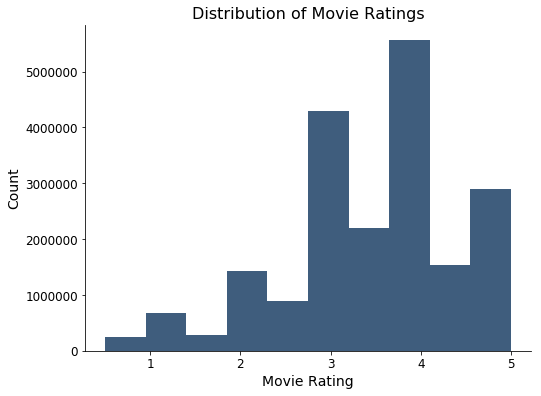

In [3]:
import matplotlib.pyplot as plt
import plotly.plotly as py
%matplotlib inline

plt.figure(figsize=(8, 6))
ax = plt.subplot(111)
ax.set_title("Distribution of Movie Ratings", fontsize=16)
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
  
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)  
  
plt.xlabel("Movie Rating", fontsize=14)  
plt.ylabel("Count", fontsize=14)  
  
plt.hist(df_ratings['rating'], color="#3F5D7D")  

plt.show()

In a standard machine learning pipeline, we would want to first separate the data into training and test sets. The test set is for the evaluation of the model. There are multiple ways to evaluate a recommender system, which affects how we split the data. You can read more [here]("https://medium.com/@m_n_malaeb/recall-and-precision-at-k-for-recommender-systems-618483226c54"). I will use precision, recall and F-1 score at K to evaluate model performance (explained in the evaluate performance section), so I'll do a stratified split on the userId. For each user, I split the movies he/she has rated to training and test data with a 70:30 ratio. With Scikit-Learn, we can do this in one line of code: 

In [4]:
from sklearn.model_selection import train_test_split

df_ratings_train, df_ratings_test= train_test_split(df_ratings,
                                                    stratify=df_ratings['userId'],
                                                    random_state = 15688,
                                                    test_size=0.30)

In [5]:
print("Number of training data: "+str(len(df_ratings_train)))
print("Number of test data: "+str(len(df_ratings_test)))

Number of training data: 14000184
Number of test data: 6000079


For our model to learn the embedding, we need to get the "word" and "sentence" equivalents from the data. Here you can imagine that each "movie" is a "word", and movies that received similar ratings from a user are in the same "sentence".

Specifically, "sentences" are generated with the below process:
For each user, generate 2 lists, which respectively stores the movies "Liked" and "Disliked" by the user. The first list contains all the movies are rated 4 points or above. The second list contains the rest of the movies. Those lists are the inputs to train the Gensim Word2Vec model.

The following code does what was said above:

In [6]:
def rating_splitter(df):
    
    df['liked'] = np.where(df['rating']>=4, 1, 0)
    df['movieId'] = df['movieId'].astype('str')
    gp_user_like = df.groupby(['liked', 'userId'])

    return ([gp_user_like.get_group(gp)['movieId'].tolist() for gp in gp_user_like.groups])

In [7]:
pd.options.mode.chained_assignment = None
splitted_movies = rating_splitter(df_ratings_train)

## Training the Model with Gensim

In this section we will feed the training data into the Gensim Word2Vec module. I will explain how to tweak the window size. You can read the full documentation for other parameters on the [official website]( https://radimrehurek.com/gensim/models/word2vec.html). I have put some explanation in the comments.

For the original Word2Vec, the window size affects the scope we searched for "contexts" to define the meaning of a given word. As the way it is defined, the window is of a fixed size. However, in our Item2Vec implementation, the "meaning" of a movie should be captured by all its neighbors in the same list. In other words, we should consider all the movies "Liked" by a user to define the "meaning" for each of those movies. This applies to all the movies "Disliked" by a user too. The window size then needs to be changed according to the size of each movie lists.

To address this problem without modifying the underlying code of the Gensim model, we first specify a very very large window size, which is way larger than the length of any movie lists in our training example. We then shuffle our training data before feeding them into the model, because the order of movies is not meaningful when defining the "meaning" of a movie using its neighbors.

The window parameter in the Gensim model is in fact random dynamic. We specify the maximum window size instead of the actual window size used. Although workaround above is not ideal, it does achieve acceptable performance. The best approach might be modifying the underlying code in Gensim directly, but that would be beyond the scope of this tutorial.

One last thing before training the mode is to make sure that Gensim is utilizing the C compiler, run the below code to verify this:

In [8]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')

import gensim
assert gensim.models.word2vec.FAST_VERSION > -1

The below code shuffles the training data:

In [19]:
import random

for movie_list in splitted_movies:
    random.shuffle(movie_list)

The below code trains the models. Two models are trained using different settings. Training the models may take a while, you can download my models [here](https://drive.google.com/open?id=1FTBsbPtYCAcS_N53MEr3VUwSqGfeIPHe) to test them out.

In [55]:
from gensim.models import Word2Vec
import datetime
start = datetime.datetime.now()

model = Word2Vec(sentences = splitted_movies, # We will supply the pre-processed list of moive lists to this parameter
                 iter = 5, # epoch
                 min_count = 10, # a movie has to appear more than 10 times to be keeped
                 size = 200, # size of the hidden layer
                 workers = 4, # specify the number of threads to be used for training
                 sg = 1, # Defines the training algorithm. We will use skip-gram so 1 is chosen.
                 hs = 0, # Set to 0, as we are applying negative sampling.
                 negative = 5, # If > 0, negative sampling will be used. We will use a value of 5.
                 window = 9999999)

print("Time passed: " + str(datetime.datetime.now()-start))
#Word2Vec.save('item2vec_20180327')

Time passed: 2:12:26.134283


In [40]:
from gensim.models import Word2Vec
import datetime
start = datetime.datetime.now()

model_w2v_sg = Word2Vec(sentences = splitted_movies,
                        iter = 10, # epoch
                        min_count = 5, # a movie has to appear more than 5 times to be keeped
                        size = 300, # size of the hidden layer
                        workers = 4, # specify the number of threads to be used for training
                        sg = 1,
                        hs = 0,
                        negative = 5,
                        window = 9999999)

print("Time passed: " + str(datetime.datetime.now()-start))
model_w2v_sg.save('item2vec_word2vecSg_20180328')
del model_w2v_sg

Time passed: 5:32:50.270232


After training, the model can be saved in your storage for future use. Note that Gensim saved all the information about the model, including the hidden weights, vocabulary frequency and the binary tree of the model, so it is possible to continue training after loading the file. This, however, is at the cost of your memory when running the model, as it would be store in your ram on the fly. If all you need is the hidden weight, it can be extract from the model seperatly. The following code demonstrate how to save, load the model and extract the word vectors.

In [16]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')

from gensim.models import Word2Vec
model = Word2Vec.load('item2vec_20180327')
word_vectors = model.wv
# del model # uncomment this line will delete the model

# Let's Make Some Recommendations!

Once the model is trained, we can use built-in methods in Gensim to do recommendations! I have written some utility wrappers to enhance the ease-of-use. But what we are really utilizing is the Gensim model.wv.most_similar_word() method. The utilities would take a user’s input, from which infer the most likely movie names based on a search on IMDB, translate them into the movieIds and feed them into the Gensim method. 

In [17]:
import requests
import re
from bs4 import BeautifulSoup

def refine_search(search_term):
    """
    Refine the movie name to be recognized by the recommender
    Args:
        search_term (string): Search Term

    Returns:
        refined_term (string): a name that can be search in the dataset
    """
    target_url = "http://www.imdb.com/find?ref_=nv_sr_fn&q="+"+".join(search_term.split())+"&s=tt"
    html = requests.get(target_url).content
    parsed_html = BeautifulSoup(html, 'html.parser')
    for tag in parsed_html.find_all('td', class_="result_text"):
        search_result = re.findall('fn_tt_tt_1">(.*)</a>(.*)</td>', str(tag))
        if search_result:
            if search_result[0][0].split()[0]=="The":
                str_frac = " ".join(search_result[0][0].split()[1:])+", "+search_result[0][0].split()[0]
                refined_name = str_frac+" "+search_result[0][1].strip()
            else:
                refined_name = search_result[0][0]+" "+search_result[0][1].strip()
    return refined_name

def produce_list_of_movieId(list_of_movieName, useRefineSearch=False):
    """
    Turn a list of movie name into a list of movie ids. The movie names has to be exactly the same as they are in the dataset.
    Ambiguous movie names can be supplied if useRefineSearch is set to True
    
    Args:
        list_of_movieName (List): A list of movie names.
        useRefineSearch (boolean): Ambiguous movie names can be supplied if useRefineSearch is set to True

    Returns:
        list_of_movie_id (List of strings): A list of movie ids.
    """
    list_of_movie_id = []
    for movieName in list_of_movieName:
        if useRefineSearch:
            movieName = refine_search(movieName)
            print("Refined Name: "+movieName)
        if movieName in name_to_movieId.keys():
            list_of_movie_id.append(str(name_to_movieId[movieName]))
    return list_of_movie_id

def recommender(positive_list=None, negative_list=None, useRefineSearch=False, topn=20):
    recommend_movie_ls = []
    if positive_list:
        positive_list = produce_list_of_movieId(positive_list, useRefineSearch)
    if negative_list:
        negative_list = produce_list_of_movieId(negative_list, useRefineSearch)
    for movieId, prob in model.wv.most_similar_cosmul(positive=positive_list, negative=negative_list, topn=topn):
        recommend_movie_ls.append(movieId)
    return recommend_movie_ls

The below code shows the top 5 recommendations to a user given that he/she likes the Disney movie “Up (2009)”:

In [18]:
ls = recommender(positive_list=["UP"], useRefineSearch=True, topn=5)
print('Recommendation Result based on "Up (2009)":')
display(df_movies[df_movies['movieId'].isin(ls)])

Refined Name: Up (2009)
Recommendation Result based on "Up (2009)":


,movieId,title,genres
11614,50872,Ratatouille (2007),Animation|Children|Drama
12746,60069,WALL·E (2008),Adventure|Animation|Children|Romance|Sci-Fi
14592,72998,Avatar (2009),Action|Adventure|Sci-Fi|IMAX
15031,76093,How to Train Your Dragon (2010),Adventure|Animation|Children|Fantasy|IMAX
15401,78499,Toy Story 3 (2010),Adventure|Animation|Children|Comedy|Fantasy|IMAX


<img src="https://drive.google.com/uc?id=1kxES3TgKLQpWo260WB_O5HHu-wY99gC2" alt="Drawing" style="width: 800px;"/>

Let’s try another one. My friend and I both like the science-fiction classic “The Matrix (1999)”. But when it comes to Quentin Tarantino's iconic "Django Unchained (2012)", we've got very different opinions. While I enjoy the ironic mix of absurdity and humor, my friend disgust the blood and violence. What would the model recommend based on our tastes? Supply those data into our model and ta-da ~ “Men in Black (1997)” and "Ghostbusters (a.k.a Ghost Busters) are on my friend's recommendation list. And I've got "Inglourious Basterds (2009)" (of course!), "Inception (2010)", and "The Dark Knight Rises (2006)".

In [19]:
ls = recommender(positive_list=["The Matrix"], negative_list=["Django Unchained"], useRefineSearch=True, topn=7)
print('Recommendation Result based on "The Matrix (1999)" minus "Django Unchained (2012)":')
display(df_movies[df_movies['movieId'].isin(ls)])

Refined Name: Matrix, The (1999)
Refined Name: Django Unchained (2012)
Recommendation Result based on "The Matrix (1999)" minus "Django Unchained (2012)":


,movieId,title,genres
1172,1197,"Princess Bride, The (1987)",Action|Adventure|Comedy|Fantasy|Romance
1528,1580,Men in Black (a.k.a. MIB) (1997),Action|Comedy|Sci-Fi
1557,1610,"Hunt for Red October, The (1990)",Action|Adventure|Thriller
1707,1777,"Wedding Singer, The (1998)",Comedy|Romance
1839,1923,There's Something About Mary (1998),Comedy|Romance
2630,2716,Ghostbusters (a.k.a. Ghost Busters) (1984),Action|Comedy|Sci-Fi
2832,2918,Ferris Bueller's Day Off (1986),Comedy


<img src="https://drive.google.com/uc?id=111Y0BQ4nAhxzrKRGgqu60E9aGrHR_EDh" alt="Drawing" style="width: 800px;"/>

In [20]:
ls = recommender(positive_list=["The Matrix", "Django Unchained"], useRefineSearch=True, topn=7)
print('Recommendation Result based on "The Matrix (1999)" + ""Django Unchained (2012)":')
display(df_movies[df_movies['movieId'].isin(ls)])

Refined Name: Matrix, The (1999)
Refined Name: Django Unchained (2012)
Recommendation Result based on "The Matrix (1999)" + ""Django Unchained (2012)":


,movieId,title,genres
11401,48780,"Prestige, The (2006)",Drama|Mystery|Sci-Fi|Thriller
12525,58559,"Dark Knight, The (2008)",Action|Crime|Drama|IMAX
13102,63082,Slumdog Millionaire (2008),Crime|Drama|Romance
13647,68157,Inglourious Basterds (2009),Action|Drama|War
14009,70286,District 9 (2009),Mystery|Sci-Fi|Thriller
15534,79132,Inception (2010),Action|Crime|Drama|Mystery|Sci-Fi|Thriller|IMAX
18312,91529,"Dark Knight Rises, The (2012)",Action|Adventure|Crime|IMAX


<img src="https://drive.google.com/uc?id=1i7qKVIL-ZjK76JnC_7IPiVIUVLVkN_2w" alt="Drawing" style="width: 800px;"/>

# Evaluating the Model Performance

How would our model perform in general when facing new data? Remember that we trained several models with different parameters. Which one is better?

To figure out the answer, an evaluation metric has to be defined. Our model produces a fixed number of recommendations on each run.The performance of this task among different models can be evaluated by the precision, recall, and F1-Score at K (K being the number of recommendations we made for each input).

In the context of our movie recommender system, precision is the ratio between “the number of successful recommendations” and “the number of all the recommendations made”. And recall is the ratio between “the number of successful recommendations” and “the number of all the movies that the user truly likes". F1-Score is the harmonic average of precision and recall.

Note that the more movies a user liked, the more likely the precision would be high and the recall would be low. On the other hand, given a fixed number of "Liked" movies, the more recommendations our model made (a larger K), the more likely the precision would be low and the recall would be high. Those are the things we need to keep in mind when interpreting precision and recall at K on a single model.

The below code extract the "LIKED" movies from the users, and evlauate the precision, recall and F1-score. Scores both models I've trained are provided.

In [12]:
def user_liked_movies_builder(model, df, for_prediction=False):
    df['liked'] = np.where(df['rating']>=4, 1, 0)
    df['movieId'] = df['movieId'].astype('str')
    df_liked = df[df['liked']==1]
    if for_prediction:
        df_liked = df[df['movieId'].isin(model.wv.vocab.keys())]
        
    user_liked_movies = df_liked.groupby('userId').agg({'movieId': lambda x: x.tolist()})['movieId'].to_dict()
    
    return user_liked_movies

def scores_at_m (model, user_liked_movies_test, user_liked_movies_training, topn=10):
    sum_liked = 0
    sum_correct = 0
    sum_total = 0
    common_users = set(user_liked_movies_test.keys()).intersection(set(user_liked_movies_training.keys()))

    for userid in common_users:
        current_test_set = set(user_liked_movies_test[userid])
        pred = [pred_result[0] for pred_result in model.wv.most_similar_cosmul(positive = user_liked_movies_training[userid], topn=topn)]
        sum_correct += len(set(pred).intersection(current_test_set))
        sum_liked += len(current_test_set)
    precision_at_m = sum_correct/(topn*len(common_users))
    recall_at_m = sum_correct/sum_liked
    f1 = 2/((1/precision_at_m)+(1/recall_at_m))
    return [precision_at_m, recall_at_m, f1]

In [23]:
pd.options.mode.chained_assignment = None
user_liked_movies_train = user_liked_movies_builder(model, df_ratings_train, for_prediction=True)
user_liked_movies_test = user_liked_movies_builder(model, df_ratings_test)

model = Word2Vec.load('item2vec_20180327')
model_score_sg1 = scores_at_m(model, user_liked_movies_test, user_liked_movies_train)
del model

In [26]:
print("Respectively, the [precision, recall, F-1 score] at 10 for our model are:")
print(model_score_sg1)  ## congrats!! haha bylu! yating

Respectively, the [precision, recall, F-1 score] at 10 for our model are:
[0.15050706688037302, 0.06892699815926419, 0.09455232322242973]


In [13]:
pd.options.mode.chained_assignment = None
model = Word2Vec.load('item2vec_word2vecSg_20180328')

user_liked_movies_train = user_liked_movies_builder(model, df_ratings_train, for_prediction=True)
user_liked_movies_test = user_liked_movies_builder(model, df_ratings_test)

model_score_sg2 = scores_at_m(model, user_liked_movies_test, user_liked_movies_train)
del model

In [14]:
print("Respectively, the [precision, recall, F-1 score] at 10 for the model are:")
print(model_score_sg2)

Respectively, the [precision, recall, F-1 score] at 10 for the model are:
[0.12680387585603964, 0.058071761671255995, 0.07966138271319025]


That's it! We've got our own recommender system with Item2vec. To explore more, do read the papers and projects in the references! 

# References

<a id='mccormick'></a>
##### [1] McCormick, C. (2016, April 19). Word2Vec Tutorial - The Skip-Gram Model. Retrieved from http://www.mccormickml.com)

##### [2] Oren Barkan and Noam Koenigstein. Item2vec: Neural item embedding for collaborative filtering. 2016

##### [3] Vitali Kuzmin. Item2Vec-based Approach to a Recommender System. 2017

##### [4] Doosan Jung. Item2vec project. https://github.com/DoosanJung/I2V_project.

##### [5] Makbule Gulcin Ozsoy. From Word Embeddings to Item Recommendation. 2016